In [ ]:
import matplotlib.pyplot as plt
import numpy as np

__AMSGrad__

**Input**: $x_1 \in \mathcal{F}$, step size $\{\alpha_t\}_{t=1}^T$, $\{\beta_{1t}\}_{t=1}^T, \beta_2$

$m_0 = 0, v_0 = 0, \hat{v_0} = 0$

**for** $t = 1$ to $T$ do

$\quad g_t = \nabla f_t (x_t)$

$\quad m_t = \beta_{1t} m_{t - 1} + (1 - \beta_{1t}) g_t$

$\quad v_t = \beta_2 v_{t - 1} + (1 - \beta_2)g_t^2$

$\quad \hat{v_t} = max(\hat{v_{t - 1}}, v_t)$

$\quad \hat{V_t} = diag(\hat{v_t})$

$\quad x_{t + 1} = \prod_{\mathcal{F}, \sqrt{\hat{V_t}}}{(x_t - \alpha_t m_t / \sqrt{\hat{v_t}})}$

**end for**

In [ ]:
def AMSGrad(x0, nablaf, projection=lambda x, V : x, alpha=lambda x : 1e-3, beta1=lambda x : 0.9, beta2=0.999, eps=1e-8, T=int(1e6)):
    m, v, v1 = 0., 0., 0.
    x = [x0]
    t = 0
    while t < T:
        t += 1
        g = nablaf(x[t - 1], t)
        m = beta1(t) * m + (1 - beta1(t)) * g
        v = beta2 * v + (1 - beta2) * np.square(g)
        v1 = np.vstack([v, v1]).max(axis=0)
        V = np.diag(v1)
        x.append(x[t - 1] - alpha(t) * m / np.sqrt(v1))
        x[t] = projection(x[t], V)

    return x

__ADAM__

**Input**: $x_1 \in \mathcal{F}$, step size $\alpha, \beta_1, \beta_2, \epsilon$

$m_0 = 0, v_0 = 0$

**for** $t = 1$ to $T$ do

$\quad g_t = \nabla f_t (x_t)$

$\quad m_t = \beta_{1t} m_{t - 1} + (1 - \beta_{1t}) g_t$

$\quad v_t = \beta_2 v_{t - 1} + (1 - \beta_2)g_t^2$

$\quad \hat{m_t} = m_t / (1 - \beta_1^t)$

$\quad \hat{v_t} = v_t / (1 - \beta_2^t)$

$\quad x_{t + 1} = \prod_{\mathcal{F}, \sqrt{\hat{V_t}}}{(x_t - \alpha_t m_t / \sqrt{\hat{v_t} + \epsilon})}$

**end for**

In [ ]:
def ADAM(x0, nablaf, projection=lambda x : x, alpha=1e-3, beta1=0.9, beta2=0.999, eps=1e-8, T=int(1e6)):
    m, m1, v, v1 = 0., 0., 0., 0.
    x = [x0]
    t = 0
    while t < T:
        t += 1
        g = nablaf(x[t - 1], t)
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g * g
        m1 = m / (1 - (beta1 ** t))
        v1 = v / (1 - (beta2 ** t))
        x.append(x[t - 1] - alpha * m1 / (np.sqrt(v1) + 1e-8))
        x[t] = projection(x[t])

    return x

__Эксперименты__

Проведем эксперименты на последовательности функций:

$f_t(x) =
  \begin{cases}
    Cx,       & \quad t \mod 3 = 1\\
    -x,  & \quad else
  \end{cases}$

  $C > 2$

In [ ]:
C = 3

In [ ]:
def f(x, t):
    if t % 3 == 1:
        return C * x
    return -1 * x

In [ ]:
def nablaf(x, t):
    if t % 3 == 1:
        return C
    return -1

Проекция на отрезок $[-1, 1]$.

In [ ]:
def projection(x, V):
    if -1 <= x and x <= 1:
        return x
    if x > 0:
        return 1
    return -1

In [ ]:
def min_f_sum(t):
    if t % 3 == 1:
        return ((C - 2) * (t // 3) + (C - 1)) * -1
    elif t % 3 == 0:
        return ((C - 2) * (t // 3) - 1) * -1
    return ((C - 2) * (t // 3)) * -1

In [ ]:
def regret(x):
    R = []
    for i in range(len(x)):
        R.append(f(x[i], i))
        if x != 0:
            R[i] += R[i - 1]

    for i in range(len(x)):
        R[i] -= min_f_sum(i)
        if i != 0:
            R[i] /= i

    return R

In [123]:
x = AMSGrad(0, nablaf, projection, T = 1e6, beta1=lambda x : 0, beta2=1e-1, alpha=lambda t: 1e-2 / np.sqrt(t))

In [124]:
R = regret(x)

In [125]:
t = np.arange(len(x))

In [101]:
def proj(x):
    return projection(x, 0)

In [118]:
adam_x = ADAM(0, nablaf, proj, T=1e6, beta1=0, beta2=1e-1)

In [119]:
adam_t = np.arange(len(adam_x))

In [120]:
adam_R = regret(adam_x)

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


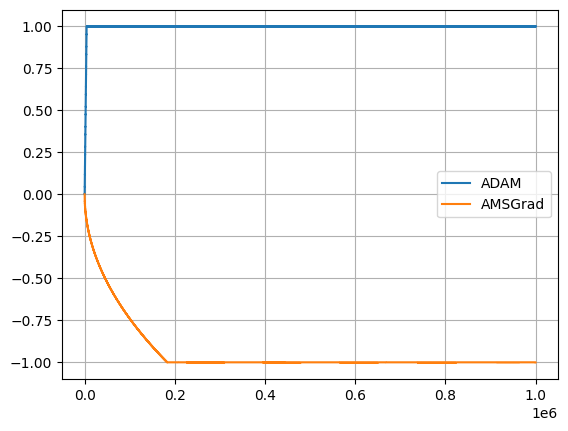

In [126]:
plt.plot(adam_t, adam_x, label="ADAM")
plt.plot(t, x, label="AMSGrad")
plt.legend()
plt.grid()
plt.show()

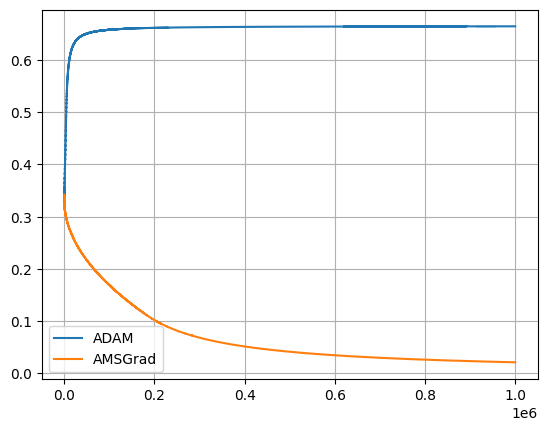

In [127]:
plt.plot(adam_t[100:], adam_R[100:], label="ADAM")
plt.plot(t[100:], R[100:], label="AMSGrad")
plt.legend()
plt.grid()
plt.show()